<a href="https://colab.research.google.com/github/flydragon2018/Analytics_Vidhya/blob/master/captcha_text_recognition_using_crnn_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18,resnet34,resnet50,resnet101,resnet152
import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [0]:
cpu_count = mp.cpu_count()
print(cpu_count)

2


## 1. Make train-test split

**Data Link**: https://www.kaggle.com/shawon10/captcha-recognition

In [0]:
!mkdir train
!mkdir test

In [0]:
from google.colab import drive
drive.mount("/content/drive")
!pwd 
!ls /content/drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content
'My Drive'


In [0]:
! cp /content/drive/"My Drive"/data/66.zip .
!ls 

66.zip	drive  sample_data  test  train


In [0]:
!unzip 66.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/1775.jpg          
  inflating: train/1776.jpg          
  inflating: train/1777.jpg          
  inflating: train/1778.jpg          
  inflating: train/1779.jpg          
  inflating: train/178.jpg           
  inflating: train/1780.jpg          
  inflating: train/1781.jpg          
  inflating: train/1782.jpg          
  inflating: train/1783.jpg          
  inflating: train/1784.jpg          
  inflating: train/1785.jpg          
  inflating: train/1786.jpg          
  inflating: train/1787.jpg          
  inflating: train/1788.jpg          
  inflating: train/1789.jpg          
  inflating: train/179.jpg           
  inflating: train/1790.jpg          
  inflating: train/1791.jpg          
  inflating: train/1792.jpg          
  inflating: train/1793.jpg          
  inflating: train/1794.jpg          
  inflating: train/1795.jpg          
  inflating: train/1796.jpg          
  inflating: train/1797.jpg          

In [0]:
!mkdir labeltrain
!ls

66.zip	drive  labeltrain  sample_data	test  train  train.csv


In [0]:
from shutil import copy

train_df=pd.read_csv("/content/train.csv")
for i in train_df.index:
    copy("/content/train/"+train_df['filename'][i], "labeltrain/"+train_df['label'][i]+".jpg")
    #print(i,train_df['filename'][i],'./labeltrain/'+train_df['label'][i]+".jpg")

In [0]:
test_files=os.listdir("/content/test")
i=len(test_files)
print("test image number=",i)

test image number= 5862


In [0]:
 
data_path = "/content/labeltrain"

In [0]:
image_fns = os.listdir(data_path)
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

5862
[4 5 6 7 8]


In [0]:
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split(".")[0]) != 8:
           print(idx, image_fn)

In [0]:
 
print(len(image_fns))

5862


In [0]:
image_fns_train, image_fns_test = train_test_split(image_fns,test_size=0.01,random_state=0)
print(len(image_fns_train), len(image_fns_test))

5803 59


## 2. Define character maps

In [0]:
image_ns = [image_fn.split(".")[0] for image_fn in image_fns]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)
#print(image_ns)

62
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [0]:
vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

63
['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{0: '-', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: 'A', 12: 'B', 13: 'C', 14: 'D', 15: 'E', 16: 'F', 17: 'G', 18: 'H', 19: 'I', 20: 'J', 21: 'K', 22: 'L', 23: 'M', 24: 'N', 25: 'O', 26: 'P', 27: 'Q', 28: 'R', 29: 'S', 30: 'T', 31: 'U', 32: 'V', 33: 'W', 34: 'X', 35: 'Y', 36: 'Z', 37: 'a', 38: 'b', 39: 'c', 40: 'd', 41: 'e', 42: 'f', 43: 'g', 44: 'h', 45: 'i', 46: 'j', 47: 'k', 48: 'l', 49: 'm', 50: 'n', 51: 'o', 52: 'p', 53: 'q', 54: 'r', 55: 's', 56: 't', 57: 'u', 58: 'v', 59: 'w', 60: 'x', 61: 'y', 62: 'z'}
{'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 1

## 3. Define data loader

In [0]:
batch_size = 16

In [0]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, image_fns):
        self.data_dir = data_dir
        self.image_fns = image_fns
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [0]:

data_path = "/content/labeltrain"
image_fns_predict = os.listdir("/content/test")

trainset = CAPTCHADataset(data_path, image_fns_train) 
testset = CAPTCHADataset(data_path, image_fns_test)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)

 
predictset = CAPTCHADataset("/content/test",image_fns_predict)
 
predict_loader = DataLoader(predictset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
print(len(train_loader), len(test_loader),len(predict_loader))

363 4 367


In [0]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([16, 3, 100, 200]) ('EL7gPTT', 'UpYAH9', 'wUyMHw1', 'eia0', 'ssog4py', 'FGfTea', 'nkFhCSkq', 'C0BeKT3O', 'PeqBGk', 'rxqO', 'gx0O', 'ofUI', '7wVr7', 'IXcD5TY', 'Uh3Mmfbc', 'xeuJV')


## 4. Define model****

In [0]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

63


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
resnet = resnet18(pretrained=True)
 
#resnet=resnet50(pretrained=True)
#resnet=resnet34(pretrained=True)
#model52=resnet152(pretrained=True)
#resnet50=resnet50(pretrained=True)

#print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        #self.linear1 = nn.Linear(1024, 256)
        self.linear1 = nn.Linear(1792, 256) 
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [0]:
class CRNN50(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN50, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet50.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(1024,1024, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        #self.linear1 = nn.Linear(1024, 256)
        self.linear1 = nn.Linear(7168, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [0]:
class CRNN101(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN101, self).__init__()
        
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            #nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.Conv2d(1024, 1024, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(1024),
            
            nn.ReLU(inplace=True)
        )
        #self.linear1 = nn.Linear(1024, 256)
        self.linear1 = nn.Linear(7168, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        #print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        #print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [0]:
#crnn50 = CRNN50(num_chars, rnn_hidden_size=rnn_hidden_size)
#crnn50.apply(weights_init)
#crnn50 = crnn50.to(device)

In [0]:
#crnn101 = CRNN101(num_chars, rnn_hidden_size=rnn_hidden_size)
#crnn101.apply(weights_init)
#crnn101 = crnn101.to(device)

In [0]:
#text_batch_logits = crnn(image_batch.to(device))
#print(text_batch)
#print(text_batch_logits.shape)

In [0]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('EL7gPTT', 'UpYAH9', 'wUyMHw1', 'eia0', 'ssog4py', 'FGfTea', 'nkFhCSkq', 'C0BeKT3O', 'PeqBGk', 'rxqO', 'gx0O', 'ofUI', '7wVr7', 'IXcD5TY', 'Uh3Mmfbc', 'xeuJV')
torch.Size([10, 16, 63])


## 5. Define loss

In [0]:
criterion = nn.CTCLoss(blank=0)

In [0]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [0]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [0]:
compute_loss(text_batch, text_batch_logits)

tensor(6.2391, device='cuda:0', grad_fn=<MeanBackward0>)

## 6. Train model

In [0]:
num_epochs = 200
lr = 0.0001
weight_decay = 1e-3
clip_norm = 5

In [0]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=10)

In [0]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [0]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

Epoch:1    Loss:4.473696560242288    NumUpdates:363


Epoch:2    Loss:4.292287134270366    NumUpdates:363


Epoch:3    Loss:4.072460621841683    NumUpdates:363


Epoch:4    Loss:3.8647224121514103    NumUpdates:363


Epoch:5    Loss:3.6781188121511916    NumUpdates:363


Epoch:6    Loss:3.483751752159812    NumUpdates:363


Epoch:7    Loss:3.290233987750429    NumUpdates:363


Epoch:8    Loss:3.112476519645081    NumUpdates:363


Epoch:9    Loss:2.9527630950465347    NumUpdates:363


Epoch:10    Loss:2.8110311392581826    NumUpdates:363


Epoch:11    Loss:2.6886255675439337    NumUpdates:363


Epoch:12    Loss:2.580790315449402    NumUpdates:363


Epoch:13    Loss:2.4863653163279382    NumUpdates:363


Epoch:14    Loss:2.398404401195936    NumUpdates:363


Epoch:15    Loss:2.3192797935370244    NumUpdates:363


Epoch:16    Loss:2.2494725517661776    NumUpdates:363


Epoch:17    Loss:2.1822141714332517    NumUpdates:363


Epoch:18    Loss:2.115534313454116    NumUpdates:363


Epoch:19    Loss:2.0562634494350633    NumUpdates:363


Epoch:20    Loss:1.996292232153501    NumUpdates:363


Epoch:21    Loss:1.942659816137687    NumUpdates:363


Epoch:22    Loss:1.8974210555888404    NumUpdates:363


Epoch:23    Loss:1.8537591364101274    NumUpdates:363


Epoch:24    Loss:1.822073699029024    NumUpdates:363


Epoch:25    Loss:1.780159151915348    NumUpdates:363


Epoch:26    Loss:1.7480149308512034    NumUpdates:363


Epoch:27    Loss:1.7155693631526852    NumUpdates:363


Epoch:28    Loss:1.6912949334819782    NumUpdates:363


Epoch:29    Loss:1.666466904409004    NumUpdates:363


Epoch:30    Loss:1.6456370212486624    NumUpdates:363


Epoch:31    Loss:1.6264174441003931    NumUpdates:363


Epoch:32    Loss:1.611799014172935    NumUpdates:363


Epoch:33    Loss:1.5888246550704495    NumUpdates:363


Epoch:34    Loss:1.5759309293810002    NumUpdates:363


Epoch:35    Loss:1.5640494902271869    NumUpdates:363


Epoch:36    Loss:1.5605264649246677    NumUpdates:363


Epoch:37    Loss:1.5520644427659427    NumUpdates:363


Epoch:38    Loss:1.5347878512600566    NumUpdates:363


Epoch:39    Loss:1.5187690609414386    NumUpdates:363


Epoch:40    Loss:1.5060515167299382    NumUpdates:363


Epoch:41    Loss:1.5040701975835584    NumUpdates:363


Epoch:42    Loss:1.499108858673369    NumUpdates:363


Epoch:43    Loss:1.4869689957826262    NumUpdates:363


Epoch:44    Loss:1.4828603986866218    NumUpdates:363


Epoch:45    Loss:1.47077262631461    NumUpdates:363


Epoch:46    Loss:1.4677160955329243    NumUpdates:363


Epoch:47    Loss:1.4638261611139807    NumUpdates:363


Epoch:48    Loss:1.4566731459509898    NumUpdates:363


Epoch:49    Loss:1.4474965632782824    NumUpdates:363


Epoch:50    Loss:1.4416492028013077    NumUpdates:363


Epoch:51    Loss:1.4416087471749173    NumUpdates:363


Epoch:52    Loss:1.4363331361250444    NumUpdates:363


Epoch:53    Loss:1.4256746598183287    NumUpdates:363


Epoch:54    Loss:1.422229803954931    NumUpdates:363


Epoch:55    Loss:1.4142510542856432    NumUpdates:363


Epoch:56    Loss:1.417636147543747    NumUpdates:363


Epoch:57    Loss:1.418922268326289    NumUpdates:363


Epoch:58    Loss:1.4085894202397875    NumUpdates:363


Epoch:59    Loss:1.3990560960506933    NumUpdates:363


Epoch:60    Loss:1.397645301070095    NumUpdates:363


Epoch:61    Loss:1.3868321025995511    NumUpdates:363


Epoch:62    Loss:1.3906959879825267    NumUpdates:363


Epoch:63    Loss:1.4003791375593706    NumUpdates:363


Epoch:64    Loss:1.396124230271857    NumUpdates:363


Epoch:65    Loss:1.3790057434523402    NumUpdates:363


Epoch:66    Loss:1.380361372117497    NumUpdates:363


Epoch:67    Loss:1.3782948446011083    NumUpdates:363


Epoch:68    Loss:1.376588970833245    NumUpdates:363


Epoch:69    Loss:1.3735548349779827    NumUpdates:363


Epoch:70    Loss:1.3734432954761937    NumUpdates:363


Epoch:71    Loss:1.3699933228085521    NumUpdates:363


Epoch:72    Loss:1.3583125989299176    NumUpdates:363


Epoch:73    Loss:1.3579671097195838    NumUpdates:363


Epoch:74    Loss:1.3527617214796628    NumUpdates:363


Epoch:75    Loss:1.3728068009552548    NumUpdates:363


Epoch:76    Loss:1.3811288155800054    NumUpdates:363


Epoch:77    Loss:1.3479022260539788    NumUpdates:363


Epoch:78    Loss:1.3351771838080455    NumUpdates:363


Epoch:79    Loss:1.3365719393921949    NumUpdates:363


Epoch:80    Loss:1.3491916922498342    NumUpdates:363


Epoch:81    Loss:1.3612083140811972    NumUpdates:363


Epoch:82    Loss:1.3523287106479824    NumUpdates:363


Epoch:83    Loss:1.3308224444875376    NumUpdates:363


Epoch:84    Loss:1.3383573280549903    NumUpdates:363


Epoch:85    Loss:1.3465814199657808    NumUpdates:363


Epoch:86    Loss:1.3298894055290327    NumUpdates:363


Epoch:87    Loss:1.3418041536630678    NumUpdates:363


Epoch:88    Loss:1.3344819351989705    NumUpdates:363


Epoch:89    Loss:1.3221327565589884    NumUpdates:363


Epoch:90    Loss:1.314640712475317    NumUpdates:363


Epoch:91    Loss:1.3326390627001927    NumUpdates:363


Epoch:92    Loss:1.33901838428718    NumUpdates:363


Epoch:93    Loss:1.331559108308524    NumUpdates:363


Epoch:94    Loss:1.3069500499520421    NumUpdates:363


Epoch:95    Loss:1.3043088220039347    NumUpdates:363


Epoch:96    Loss:1.3540438528560081    NumUpdates:363


Epoch:97    Loss:1.3343722895814039    NumUpdates:363


Epoch:98    Loss:1.3073975399505993    NumUpdates:363


Epoch:99    Loss:1.2975719667991659    NumUpdates:363


Epoch:100    Loss:1.3099141735019106    NumUpdates:363


Epoch:101    Loss:1.3350876208507654    NumUpdates:363


Epoch:102    Loss:1.3131681188078952    NumUpdates:363


Epoch:103    Loss:1.3177239096854343    NumUpdates:363


Epoch:104    Loss:1.3094790944054764    NumUpdates:363


Epoch:105    Loss:1.3007637331308413    NumUpdates:363


Epoch:106    Loss:1.2878474538976497    NumUpdates:363


Epoch:107    Loss:1.2887028738158466    NumUpdates:363


Epoch:108    Loss:1.291262167216004    NumUpdates:363


Epoch:109    Loss:1.3242601106974705    NumUpdates:363


Epoch:110    Loss:1.3502876834107496    NumUpdates:363


Epoch:111    Loss:1.3043885178474026    NumUpdates:363


Epoch:112    Loss:1.2795803908145789    NumUpdates:363


Epoch:113    Loss:1.2721759537363184    NumUpdates:363


Epoch:114    Loss:1.2798868920192246    NumUpdates:363


Epoch:115    Loss:1.296969715557151    NumUpdates:363


Epoch:116    Loss:1.3375712964817184    NumUpdates:363


Epoch:117    Loss:1.3014163596570985    NumUpdates:363


Epoch:118    Loss:1.28495904696546    NumUpdates:363


Epoch:119    Loss:1.2734751284286667    NumUpdates:363


Epoch:120    Loss:1.2664224434818447    NumUpdates:363


Epoch:121    Loss:1.2618618123130694    NumUpdates:363


Epoch:122    Loss:1.2931248649092746    NumUpdates:363


Epoch:123    Loss:1.3295395761810387    NumUpdates:363


Epoch:124    Loss:1.3056840157705891    NumUpdates:363


Epoch:125    Loss:1.2761635721222429    NumUpdates:363


Epoch:126    Loss:1.26024677109784    NumUpdates:363


Epoch:127    Loss:1.2554057389908257    NumUpdates:363


Epoch:128    Loss:1.2545810612765225    NumUpdates:363


Epoch:129    Loss:1.279406477597134    NumUpdates:363


Epoch:130    Loss:1.3333418172253064    NumUpdates:363


Epoch:131    Loss:1.2963985914041187    NumUpdates:363


Epoch:132    Loss:1.2659182039502568    NumUpdates:363


Epoch:133    Loss:1.2532124135119855    NumUpdates:363


Epoch:134    Loss:1.2499730728217722    NumUpdates:363


Epoch:135    Loss:1.2551862007987071    NumUpdates:363


Epoch:136    Loss:1.3215776202435665    NumUpdates:363


Epoch:137    Loss:1.3009078259638847    NumUpdates:363


Epoch:138    Loss:1.2781109777035464    NumUpdates:363


Epoch:139    Loss:1.2566071962193681    NumUpdates:363


Epoch:140    Loss:1.251243418570064    NumUpdates:363


Epoch:141    Loss:1.2582348851132985    NumUpdates:363


Epoch:142    Loss:1.2530813919939614    NumUpdates:363


Epoch:143    Loss:1.265936694526147    NumUpdates:363


Epoch:144    Loss:1.2821873820517673    NumUpdates:363


Epoch:145    Loss:1.2731891239970183    NumUpdates:363
Epoch   145: reducing learning rate of group 0 to 1.0000e-05.


Epoch:146    Loss:1.2050037072052968    NumUpdates:363


Epoch:147    Loss:1.1840709681024892    NumUpdates:363


Epoch:148    Loss:1.1770999086789848    NumUpdates:363


Epoch:149    Loss:1.1723668427506755    NumUpdates:363


Epoch:150    Loss:1.168958700392857    NumUpdates:363


Epoch:151    Loss:1.1661978454300852    NumUpdates:363


Epoch:152    Loss:1.1638962936795447    NumUpdates:363


Epoch:153    Loss:1.1617879079393119    NumUpdates:363


Epoch:154    Loss:1.1600774352543939    NumUpdates:363


Epoch:155    Loss:1.1584163024077403    NumUpdates:363


Epoch:156    Loss:1.1568495015467495    NumUpdates:363


Epoch:157    Loss:1.1554138049606448    NumUpdates:363


Epoch:158    Loss:1.1541741147185818    NumUpdates:363


Epoch:159    Loss:1.152792991357073    NumUpdates:363


Epoch:160    Loss:1.1518225985125077    NumUpdates:363


Epoch:161    Loss:1.1505181500405977    NumUpdates:363


Epoch:162    Loss:1.1494578517172946    NumUpdates:363


Epoch:163    Loss:1.1484292748874212    NumUpdates:363


Epoch:164    Loss:1.1474797742097502    NumUpdates:363


Epoch:165    Loss:1.146312359607581    NumUpdates:363


Epoch:166    Loss:1.1456321333393906    NumUpdates:363


Epoch:167    Loss:1.1447190621010856    NumUpdates:363


Epoch:168    Loss:1.1437979778967613    NumUpdates:363


Epoch:169    Loss:1.1431692503700572    NumUpdates:363


Epoch:170    Loss:1.1419905624442193    NumUpdates:363


Epoch:171    Loss:1.1412085462207637    NumUpdates:363


Epoch:172    Loss:1.1405821017325746    NumUpdates:363


Epoch:173    Loss:1.1396553733132102    NumUpdates:363


Epoch:174    Loss:1.138915090521505    NumUpdates:363


Epoch:175    Loss:1.138219991006142    NumUpdates:363


Epoch:176    Loss:1.1376195098414565    NumUpdates:363


Epoch:177    Loss:1.1370150205517604    NumUpdates:363


Epoch:178    Loss:1.136438172054028    NumUpdates:363


Epoch:179    Loss:1.1360572973887126    NumUpdates:363


Epoch:180    Loss:1.1351684262929869    NumUpdates:363


Epoch:181    Loss:1.1345053990025165    NumUpdates:363


Epoch:182    Loss:1.1339818409980165    NumUpdates:363


Epoch:183    Loss:1.1334856952189085    NumUpdates:363


Epoch:184    Loss:1.13279278514799    NumUpdates:363


Epoch:185    Loss:1.1319717378984142    NumUpdates:363


Epoch:186    Loss:1.1313391864792375    NumUpdates:363


Epoch:187    Loss:1.131213385539935    NumUpdates:363


Epoch:188    Loss:1.1305452171436026    NumUpdates:363


Epoch:189    Loss:1.1300600696529568    NumUpdates:363


Epoch:190    Loss:1.1296487100853407    NumUpdates:363


Epoch:191    Loss:1.1287970904147986    NumUpdates:363


Epoch:192    Loss:1.1286312249737995    NumUpdates:363


Epoch:193    Loss:1.1278907162427245    NumUpdates:363


Epoch:194    Loss:1.1274734971937068    NumUpdates:363


Epoch:195    Loss:1.1269192758013722    NumUpdates:363


Epoch:196    Loss:1.1264999848751982    NumUpdates:363


Epoch:197    Loss:1.1261129461372523    NumUpdates:363


Epoch:198    Loss:1.1256398066016269    NumUpdates:363


Epoch:199    Loss:1.1253467492820803    NumUpdates:363


Epoch:200    Loss:1.1247442615918877    NumUpdates:363



In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

## 7. Make predictions

In [0]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [0]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

In [0]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

In [0]:
print(results_train.shape)
results_train.head()

(5803, 2)


,actual,prediction
0,HqZm,HHqqqZZmmm
1,Zjik,Zjjiikk---
2,HVBuOp2,HVBuuOOpp2
3,AeY5C7ts,AeYY5C77ts
4,UO8WvGg,UOO88WWvGg


In [0]:
print(results_test.shape)
results_test.head()

(59, 2)


,actual,prediction
0,tBMX,tBBBMMxxxx
1,fDNw,fffDDDNNww
2,TI0j,TII000jjjj
3,a8CUW6YP,a8CWW6YYPP
4,1N0U,1111NNNoUU


In [0]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [0]:
results_train['corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,corrected
0,HqZm,HHqqqZZmmm,HqZm
1,Zjik,Zjjiikk---,Zjik
2,HVBuOp2,HVBuuOOpp2,HVBuOp2
3,AeY5C7ts,AeYY5C77ts,AeY5C7ts
4,UO8WvGg,UOO88WWvGg,UO8WvGg


In [0]:
results_test['corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,corrected
0,tBMX,tBBBMMxxxx,tBMx
1,fDNw,fffDDDNNww,fDNw
2,TI0j,TII000jjjj,TI0j
3,a8CUW6YP,a8CWW6YYPP,a8CW6YP
4,1N0U,1111NNNoUU,1NoU


## 8. Evaluate the model

In [0]:
mistakes_df = results_test[results_test['actual'] != results_test['corrected']]
mistakes_df

,actual,prediction,corrected
0,tBMX,tBBBMMxxxx,tBMx
3,a8CUW6YP,a8CWW6YYPP,a8CW6YP
4,1N0U,1111NNNoUU,1NoU
5,16KQKp,6KKKQKKKpp,6KQKp
6,q0ym,qOOOmmm---,qOm
8,KXsMO4gq,XssMM044gq,XsM04gq
9,B3mLOJ,BBB3mmL0JJ,B3mL0J
10,wxY4Sc,wwwYY4SScc,wY4Sc
12,Fxsj,FXXsssjjjj,FXsj
17,4ZYYRd0,ZZYYYYRRd0,ZYRd0


In [0]:
print(mistakes_df['corrected'].str.len().value_counts())

5    17
6     7
7     4
4     4
3     2
Name: corrected, dtype: int64


In [0]:
mask = mistakes_df['corrected'].str.len() < 5
mistakes_df[mask]

,actual,prediction,corrected
0,tBMX,tBBBMMxxxx,tBMx
4,1N0U,1111NNNoUU,1NoU
6,q0ym,qOOOmmm---,qOm
12,Fxsj,FXXsssjjjj,FXsj
24,rd7LDIDG,rdddDDDDDG,rdDG
41,U2W2A,UUU22222AA,U2A


/content/labeltrain/tBMX.jpg


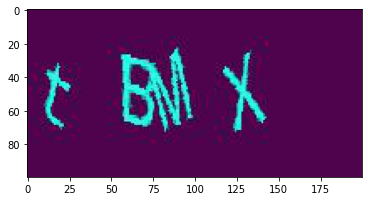

In [0]:
mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".jpg")
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

In [0]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction'])
print(test_accuracy)

0.0
0.0


In [0]:
train_accuracy = accuracy_score(results_train['actual'], results_train['corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['corrected'])
print(test_accuracy)

0.9715664311562985
0.423728813559322


In [0]:

results=[]
predict_loader = DataLoader(predictset, batch_size=1, num_workers=1, shuffle=False)
with torch.no_grad():
    i=0
    for image_batch, text_batch in tqdm(predict_loader, leave=True):
        
        print(i,text_batch)
        #print(image_batch, text_batch)
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(i,text_batch, text_batch_pred)
        results.append([i,text_batch[0],text_batch_pred]) 
        
        print(results[i]) 
        i+=1
#results_predict = results_predict.reset_index(drop=True)


Streaming output truncated to the last 5000 lines.
3363 ('686',)
[3363, '686', ['LLwwwTQQnn']]
3364 ('2464',)
[3364, '2464', ['YYYiiii33C']]
3365 ('385',)
[3365, '385', ['ii7AAnhhRR']]
3366 ('2813',)
[3366, '2813', ['XX666111FF']]
3367 ('1103',)
[3367, '1103', ['TTTCCqqQQQ']]
3368 ('2075',)
[3368, '2075', ['mmEJJJxxxx']]
3369 ('2928',)
[3369, '2928', ['qqq2ookkCC']]
3370 ('1848',)
[3370, '1848', ['CCfffN33GG']]
3371 ('2952',)
[3371, '2952', ['1KKKTTTPPP']]
3372 ('1128',)
[3372, '1128', ['xeellMMMXR']]
3373 ('40',)
[3373, '40', ['IIIllHKKYz']]
3374 ('3377',)
[3374, '3377', ['hhhSXXXjFF']]
3375 ('444',)
[3375, '444', ['ZZZkkNNN77']]
3376 ('1963',)
[3376, '1963', ['PP2RRR00KK']]
3377 ('1996',)
[3377, '1996', ['wwOw99GLLa']]
3378 ('2177',)
[3378, '2177', ['VVjdd44kk0']]
3379 ('1802',)
[3379, '1802', ['ioRRRCCC--']]
3380 ('3907',)
[3380, '3907', ['99HHcjWWWa']]
3381 ('858',)
[3381, '858', ['ccZZddHHnl']]
3382 ('25',)
[3382, '25', ['UUUCCZQ22m']]
3383 ('3524',)
[3383, '3524', ['11XXzzD022']]

In [0]:
results_predict = pd.DataFrame(results,columns=['idx','num','prediction'])
results_predict[:5]
predicts=results_predict

In [0]:
for i in   range(len(results_predict)):
    predicts['prediction'][i] =results_predict['prediction'][i][0][1:-1]
predicts[:5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,idx,num,prediction
0,0,23,U88ss88B
1,1,4780,JIIxxEEE
2,2,1801,00V1166m
3,3,3959,mmvhhDDN
4,4,3730,pp88nSSW


In [0]:
predicts['corrected'] = predicts['prediction'].apply(correct_prediction)
predicts.head()

,idx,num,prediction,corrected
0,0,23,U88ss88B,U8s8B
1,1,4780,JIIxxEEE,JIxE
2,2,1801,00V1166m,0V16m
3,3,3959,mmvhhDDN,mvhDN
4,4,3730,pp88nSSW,p8nSW


In [0]:

submission=pd.DataFrame(predicts,columns=['num','corrected'])
print(type(submission))
submission

<class 'pandas.core.frame.DataFrame'>


,num,corrected
0,23,U8s8B
1,4780,JIxE
2,1801,0V16m
3,3959,mvhDN
4,3730,p8nSW
...,...,...
5857,5307,hwlo
5858,5456,2DGr
5859,212,bmMRb
5860,3386,9l46


In [0]:
submission.to_csv("predict_submission.csv",header=None,index=None)

In [0]:
!ls *.csv
from google.colab import files
files.download("predict_submission.csv")

predict_submission.csv	train.csv
